#**NFL Hall of Fame Predictor**
Every year 4-8 retired NFL players are inducted into the prestigious Hall of Fame in Canton, Ohio. This is one of the biggest honors that an NFL player can recieve, and you have to play at a very high level throughout your career to have a chance of being inducted. Making the Hall of Fame is no easy task, and out of almost 26,000 NFL players, only 300 have made the HOF (1.1%). There are several factors that the selection committe looks at to determine whether a player is worthy of making the Hall of Fame, such as career stats, playoff appearances, super bowl championships, etc. I believe its possible to predict whether a QB, RB or WR will make the Hall of Fame by just looking at career stats, and the goal of this project is to accomplish this using a linear regression estimator. 

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.utils import shuffle
from IPython.display import clear_output

##**Data Preperation**

References:

https://www.pro-football-reference.com/hof/#hof_players

https://www.kaggle.com/kendallgillies/nflstatistics

In [ ]:
# Upload NFL_HOF, Career_Stats_Passing, Career_Stats_Rushing, and Career_Stats_Passing CSV Files
from google.colab import files
uploaded = files.upload()

Saving Career_Stats_Passing.csv to Career_Stats_Passing.csv
Saving Career_Stats_Receiving.csv to Career_Stats_Receiving.csv
Saving Career_Stats_Rushing.csv to Career_Stats_Rushing.csv
Saving NFL_Hof.csv to NFL_Hof.csv


In [ ]:
hall_of_famers = pd.read_csv("NFL_Hof.csv").reset_index(drop = True)

**Key**

Pos: Position

G: Games Played

Cmp: Passes Completed

Att: Passes Attempted

Yds: Passing Yards

TD: Passing Touchdowns

Int: Interceptions

Att.1: Rushing Attempts

Yds.1: Rushing Yards

Td.1: Rushing Touchdowns

Lng: Longest rush

Rec: Receptions (Passes Caught)

Yds.2: Recieving Yards

TD.2: Recieving TDs

Lng.1: Longest reception



In [ ]:
hall_of_famers

,Player,Pos,AP1,PB,St,CarAV,G,Cmp,Att,Yds,TD,Int,Att.1,Yds.1,TD.1,Lng,Rec,Yds.2,TD.2,Lng.1
0,Alan Faneca,G,6,9,13,107,206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Johnson, Calvin",WR,3,6,9,78,135,NaN,NaN,NaN,NaN,NaN,19.0,167.0,1.0,32.0,731.0,11619.0,83.0,96.0
2,John Lynch\LyncJo00,DB,2,9,13,85,224,NaN,NaN,NaN,NaN,NaN,1.0,40.0,0.0,40.0,NaN,NaN,NaN,NaN
3,"Manning, Peyton",QB,7,14,17,176,266,6125.0,9380.0,71940.0,539.0,251.0,431.0,667.0,18.0,33.0,1.0,-2.0,0.0,0.0
4,"Pearson, Drew",WR,3,3,10,78,156,5.0,7.0,192.0,3.0,2.0,21.0,189.0,0.0,33.0,489.0,7822.0,48.0,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Cal Hubbard\HubbCa20,T,4,0,6,0,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0
296,Don Hutson\HutsDo00,E,8,4,8,0,116,1.0,11.0,38.0,1.0,2.0,62.0,284.0,3.0,27.0,488.0,7991.0,99.0,92.0
297,Bronko Nagurski\NaguBr00,FB,4,0,7,0,97,32.0,77.0,474.0,7.0,9.0,633.0,2778.0,25.0,11.0,11.0,134.0,0.0,23.0
298,Ernie Nevers\NeveEr20,FB,5,0,5,0,54,NaN,NaN,NaN,NaN,NaN,0.0,0.0,38.0,0.0,NaN,NaN,NaN,NaN


We will only be looking at data from QB, RB, and WRs since there are several more databases on these three positions. As a result, we will start by seperating into three different datasets based on position and then dropping all the columns that are not required.

In [ ]:
hof_qb = hall_of_famers[hall_of_famers.Pos == "QB"][hall_of_famers.columns[0:12]].drop(["Pos", "AP1", "PB", "CarAV", "St"], axis = 1)

hof_rb = hall_of_famers[hall_of_famers.Pos == "RB"][hall_of_famers.columns[0:16]].drop(["Pos", "AP1", "PB", "CarAV", "St", "Cmp", "Att", "Yds", "TD", "Int", "Lng"], axis = 1)

hof_wr = hall_of_famers[hall_of_famers.Pos == "WR"][hall_of_famers.columns[0:25]].drop(["Pos", "AP1", "PB", "CarAV", "St", "Cmp", "Att", "Yds", "TD", "Int", "Att.1", "Yds.1", "TD.1","Lng", "Lng.1"], axis = 1)

In [ ]:
hof_rb

,Player,G,Att.1,Yds.1,TD.1
14,"James, Edgerrin",148,3028.0,12246.0,80.0
35,"Davis, Terrell",78,1655.0,7607.0,60.0
38,"Tomlinson, LaDainian",170,3174.0,13684.0,145.0
46,"Bettis, Jerome",192,3479.0,13662.0,91.0
69,"Martin, Curtis",168,3518.0,14101.0,90.0
72,"Faulk, Marshall",176,2836.0,12279.0,100.0
80,"Little, Floyd",117,1641.0,6323.0,43.0
83,"Smith, Emmitt",226,4409.0,18355.0,164.0
99,"Thomas, Thurman",182,2877.0,12074.0,65.0
113,"Sanders, Barry",153,3062.0,15269.0,99.0


###**Hall of Fame Quarterbacks**

Now that we have all the data of HOF players, we will also need to add data of players that are not in the HOF so that our model has something to compare to.

In [ ]:
qb_career = pd.read_csv("Career_Stats_Passing.csv")

qb_career = qb_career.replace(["--"], np.NaN)

qb_career['Cmp'] = qb_career['Cmp'].str.replace(',', '').astype(float)
qb_career['Att'] = qb_career['Att'].str.replace(',', '').astype(float)
qb_career["Yds"] = qb_career['Yds'].str.replace(',', '').astype(float)
qb_career['TD'] = qb_career['TD'].str.replace(',', '').astype(float)
qb_career['Int'] = qb_career['Int'].str.replace(',', '').astype(float)


In [ ]:
qb_career = qb_career.groupby("Player").sum().reset_index()

qb_career["Cmp%"] = ((qb_career["Cmp"] / qb_career["Att"]).round(decimals = 2))*100
qb_career["YPG"] = (qb_career["Yds"] / qb_career["G"]).round(decimals = 2)

In [ ]:
# Hall of Fame = 1, Not in Hall of Fame = 0
hof_qb["HOF"] = 1

hof_qb["Cmp%"] = ((hof_qb["Cmp"] / hof_qb["Att"]).round(decimals = 2))*100
hof_qb["YPG"] = (hof_qb["Yds"] / hof_qb["G"]).round(decimals = 2)

In [ ]:
all_qbs = pd.concat([hof_qb, qb_career]).drop_duplicates(subset = "Player").reset_index(drop = True)

# Make HOF last column
qbs_hof_copy = all_qbs.pop("HOF")
all_qbs["HOF"] = qbs_hof_copy

**Key**

Cmp%: Completion Percentage

YPG: Yards per game

HOF: Hall of Famer?

In [ ]:
all_qbs

,Player,G,Cmp,Att,Yds,TD,Int,Cmp%,YPG,HOF
0,"Manning, Peyton",266,6125.0,9380.0,71940.0,539.0,251.0,65.0,270.45,1.0
1,"Warner, Kurt",124,2666.0,4070.0,32344.0,208.0,128.0,66.0,260.84,1.0
2,"Favre, Brett",302,6300.0,10169.0,71838.0,508.0,336.0,62.0,237.87,1.0
3,"Stabler, Ken",184,2270.0,3793.0,27938.0,194.0,222.0,60.0,151.84,1.0
4,"Aikman, Troy",165,2898.0,4715.0,32942.0,165.0,141.0,61.0,199.65,1.0
...,...,...,...,...,...,...,...,...,...,...
1326,"Zofko, Mickey",44,1.0,1.0,35.0,0.0,0.0,100.0,0.80,NaN
1327,"Zolak, Scott",55,124.0,248.0,1314.0,8.0,7.0,50.0,23.89,NaN
1328,"Zontini, Lou",26,2.0,2.0,18.0,0.0,0.0,100.0,0.69,NaN
1329,"Zoppetti, Frank",4,0.0,1.0,0.0,0.0,0.0,0.0,0.00,NaN


There are some QBs that are guaranteed to make the hall of fame in the future but are not currently enshrined, because players have to wait 5 years after they retire to be considered. We will label these players as hall of famers in our data so our model can be trained properly

In [ ]:
all_qbs.HOF = all_qbs.HOF.replace([np.nan], 0)

future_hof_qbs = ["Brady, Tom", "Brees, Drew", "Roethlisberger, Ben", "Rodgers, Aaron", "Manning, Eli", "Rivers, Philip", "Romo, Tony"]
for hof in future_hof_qbs:
  all_qbs.HOF[all_qbs.Player == hof] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


##**Training Model**

In [ ]:
all_qbs = shuffle(all_qbs)

# Training Data (80%)
qb_train = all_qbs[0:1064]
qb_train_results = qb_train.pop("HOF")

# Testing Data (20%)
qb_test = all_qbs[1064:-1]
qb_test_results = qb_test.pop("HOF")

In [ ]:
feature_columns_qbs = []
columns = ["G", "Cmp", "Att", "Yds", "TD", "Int", "Cmp%", "YPG"]

for column in columns:
  feature_columns_qbs.append(tf.feature_column.numeric_column(column, dtype=tf.float32))

In [ ]:
def make_input_fn(data_df, label_df, num_epochs=30, shuffle=True, batch_size=32):
  def input_function():  
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  
    if shuffle:
      ds = ds.shuffle(1000)  
    ds = ds.batch(batch_size).repeat(num_epochs)  
    return ds  
  return input_function  

train_input_fn_qb = make_input_fn(qb_train, qb_train_results)  
eval_input_fn_qb = make_input_fn(qb_test, qb_test_results, num_epochs=1, shuffle=False)

In [ ]:
linear_est_qbs = tf.estimator.LinearClassifier(feature_columns = feature_columns_qbs)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpn_reikri', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpn_reikri/model.ckpt-1020
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1020...
INFO:tensorflow:Saving checkpoints for 1020 into /tmp/tmpn_reikri/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1020...
INFO:tensorflow:loss = 5.056885e-06, step = 1020
INFO:tensorflow:global_step/sec: 460.408
INFO:tensorflow:loss = 0.00015532531, step = 1120 (0.222 sec)
INFO:tensorflow:global_step/sec: 774.613
INFO:tensorflow:loss = 0.00045820134, step = 1220 (0.127 sec)
INFO:tensorflow:global_step/sec: 800.805
INFO:tensorflow:loss = 1.1471535e-06, step = 1320 (0.127 sec)
INFO:tensorflow:global_step/sec: 837.584
INFO:tensorflow:loss = 2.804782e-05, step = 1420 (0.119 sec)
INFO:tensorflow:global_step/s

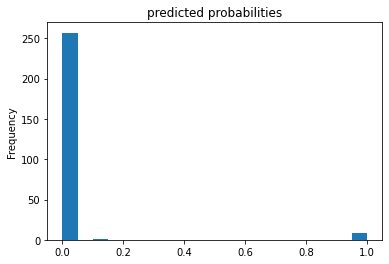

In [ ]:
linear_est_qbs.train(train_input_fn_qb)  
result = linear_est_qbs.evaluate(eval_input_fn_qb)   

pred_dicts = list(linear_est_qbs.predict(eval_input_fn_qb))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='predicted probabilities')

print("\nAccuracy", result['accuracy']) 

Our model has a 99% accuracy rate, but since there are far more players that are not in the HOF in the data set, it is easy to draw a distinction between the two. There are also several players in the dataset that have only played a few games in the NFL, and it is clear that these players have basically no chance of making the hall of fame. To make sure that our model is working properly, we will use another dataset with equal amounts of players that are in the HOF and not in the HOF. The players in the data set will also have decent careers in the NFL.

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-08-11T18:42:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpn_reikri/model.ckpt-2040
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.56974s
INFO:tensorflow:Finished evaluation at 2021-08-11-18:42:17
INFO:tensorflow:Saving dict for global step 2040: accuracy = 0.8269231, accuracy_baseline = 0.5576923, auc = 0.83583206, auc_precision_recall = 0.8169638, average_loss = 17.090244, global_step = 2040, label/mean = 0.5576923, loss = 15.430073, precision = 0.8333333, prediction/mean = 0.5864945, recall = 0.86206895
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2040: /tmp/tmpn_reikri/model.ckpt-2040
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpn_reikri/model.ckpt-2040
IN

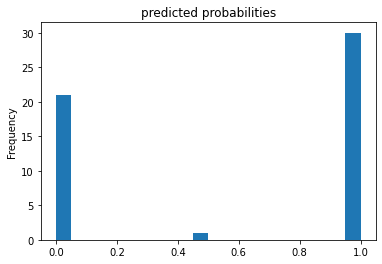

In [ ]:
# Revised Testing Data
qb_random = qb_career[qb_career.Cmp > 1000].sample(30)
revised_qb_test = pd.concat([hof_qb, qb_random]).drop_duplicates(subset = "Player").reset_index(drop = True)
revised_qb_test.HOF = revised_qb_test.HOF.replace([np.nan], 0)
revised_qb_test = shuffle(revised_qb_test)
revised_qb_results = revised_qb_test.pop("HOF")

eval_input_fn_qb = make_input_fn(revised_qb_test, revised_qb_results, num_epochs=1, shuffle=False)

result = linear_est_qbs.evaluate(eval_input_fn_qb)  

pred_dicts = list(linear_est_qbs.predict(eval_input_fn_qb))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='predicted probabilities')
print("\nAccuracy", result['accuracy']) 

In [ ]:
qb_random

,Player,G,Cmp,Att,Yds,TD,Int,Cmp%,YPG
341,"Fitzpatrick, Ryan",127,2315.0,3876.0,25888.0,166.0,133.0,60.0,203.84
505,"Hart, Jim",201,2593.0,5076.0,34665.0,209.0,247.0,51.0,172.46
565,"Johnson, Brad",177,2668.0,4326.0,29054.0,166.0,122.0,62.0,164.15
387,"Gannon, Rich",157,2533.0,4206.0,28743.0,180.0,104.0,60.0,183.08
1097,"Schroeder, Jay",118,1426.0,2808.0,20063.0,114.0,108.0,51.0,170.03
119,"Brady, Tom",237,5244.0,8224.0,61582.0,456.0,152.0,64.0,259.84
738,"Luck, Andrew",70,1570.0,2651.0,19078.0,132.0,68.0,59.0,272.54
459,"Hadl, John",224,2363.0,4687.0,33503.0,244.0,268.0,50.0,149.57
342,"Flacco, Joe",138,2915.0,4742.0,32639.0,182.0,117.0,61.0,236.51
390,"Garcia, Jeff",125,2264.0,3676.0,25537.0,161.0,83.0,62.0,204.30


As you can see, our model is still accurate with the revised testing data. Now we can just repeat the same process on running backs and wide recievers.

###**Hall of Fame Wide Recievers**

In [ ]:
hof_wr

,Player,G,Rec,Yds.2,TD.2
1,"Johnson, Calvin",135,731.0,11619.0,83.0
4,"Pearson, Drew",156,489.0,7822.0,48.0
7,"Bruce, Isaac",223,1024.0,15208.0,91.0
8,"Carmichael, Harold",182,590.0,8985.0,79.0
31,"Moss, Randy",218,982.0,15292.0,156.0
32,"Owens, Terrell",219,1078.0,15934.0,153.0
42,"Harrison, Marvin",190,1102.0,14580.0,128.0
47,"Brown, Tim",255,1094.0,14934.0,100.0
56,"Reed, Andre",234,951.0,13198.0,87.0
60,"Carter, Cris",234,1101.0,13899.0,130.0


In [ ]:
wr_career = pd.read_csv("Career_Stats_Receiving.csv")

# Cleaning Data
wr_career = wr_career.replace(["--"], np.NaN)

wr_career['Rec'] = wr_career['Rec'].str.replace(',', '').astype(float)
wr_career["Yds.2"] = wr_career['Yds.2'].str.replace(',', '').astype(float)
wr_career['TD.2'] = wr_career['TD.2'].str.replace(',', '').astype(float)

wr_career = wr_career.groupby("Player")[["G", "Rec", "Yds.2", "TD.2"]].sum().reset_index()

#Add Columns
hof_wr["YPR"] = (hof_wr["Yds.2"] / hof_wr["Rec"]).round(decimals = 2)
hof_wr["YPG"] = (hof_wr["Yds.2"] / hof_wr["G"]).round(decimals = 2)
hof_wr["RPG"] = (hof_wr["Rec"] / hof_wr["G"]).round(decimals = 2)

wr_career["YPR"] = (wr_career["Yds.2"] / wr_career["Rec"]).round(decimals = 2)
wr_career["YPG"] = (wr_career["Yds.2"] / wr_career["G"]).round(decimals = 2)
wr_career["RPG"] = (wr_career["Rec"] / wr_career["G"]).round(decimals = 2)

hof_wr["HOF"] = 1

all_wrs = pd.concat([hof_wr, wr_career]).drop_duplicates(subset = "Player").reset_index(drop = True)

all_wrs.HOF = all_wrs.HOF.replace([np.nan], 0)
# Make HOF last column
wrs_hof_copy = all_wrs.pop("HOF")
all_wrs["HOF"] = wrs_hof_copy

**Key**

YPR: Yards per reeception

YPG: Yards per game

RPG: Receptions per game

HOF: Hall of Famer?

In [ ]:
all_wrs

,Player,G,Rec,Yds.2,TD.2,YPR,YPG,RPG,HOF
0,"Johnson, Calvin",135,731.0,11619.0,83.0,15.89,86.07,5.41,1.0
1,"Pearson, Drew",156,489.0,7822.0,48.0,16.00,50.14,3.13,1.0
2,"Bruce, Isaac",223,1024.0,15208.0,91.0,14.85,68.20,4.59,1.0
3,"Carmichael, Harold",182,590.0,8985.0,79.0,15.23,49.37,3.24,1.0
4,"Moss, Randy",218,982.0,15292.0,156.0,15.57,70.15,4.50,1.0
...,...,...,...,...,...,...,...,...,...
3540,"Zimmerman, Roy",84,5.0,36.0,0.0,7.20,0.43,0.06,0.0
3541,"Zofko, Mickey",44,7.0,45.0,0.0,6.43,1.02,0.16,0.0
3542,"Zontini, Lou",26,4.0,110.0,1.0,27.50,4.23,0.15,0.0
3543,"Zorn, Jim",140,1.0,27.0,0.0,27.00,0.19,0.01,0.0


In [ ]:
future_hof_wrs = ["Fitzgerald, Larry", "Jones, Julio", "Brown, Antonio", "Smith Sr., Steve", "Johnson, Andre", "Wayne, Reggie"]
for hof in future_hof_wrs:
  all_wrs.HOF[all_wrs.Player == hof] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
all_wrs = shuffle(all_wrs)

# Training Data (80%)
wr_train = all_wrs[0:2836]
wr_train_results = wr_train.pop("HOF")

# Testing Data (20%)
wr_test = all_wrs[2836:-1]
wr_test_results = wr_test.pop("HOF")

# Revised Testing Data
wr_random = wr_career[wr_career.Rec > 200].sample(30)
revised_wr_test = pd.concat([hof_wr, wr_random]).drop_duplicates(subset = "Player").reset_index(drop = True)
revised_wr_test.HOF = revised_wr_test.HOF.replace([np.nan], 0)
revised_wr_test = shuffle(revised_wr_test)
revised_wr_results = revised_wr_test.pop("HOF")

# Feature Columns
feature_columns_wrs = []
columns = ["G", "Rec", "Yds.2", "TD.2", "YPR", "YPG", "RPG"]

for column in columns:
  feature_columns_wrs.append(tf.feature_column.numeric_column(column, dtype=tf.float32))


In [ ]:
train_input_fn_wr = make_input_fn(wr_train, wr_train_results)  
eval_input_fn_wr = make_input_fn(wr_test, wr_test_results, num_epochs=1, shuffle=False)

linear_est_wrs = tf.estimator.LinearClassifier(feature_columns = feature_columns_wrs)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpdacmhncb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdacmhncb/model.ckpt-2670
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 2670...
INFO:tensorflow:Saving checkpoints for 2670 into /tmp/tmpdacmhncb/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 2670...
INFO:tensorflow:loss = 3.912271e-06, step = 2670
INFO:tensorflow:global_step/sec: 498.662
INFO:tensorflow:loss = 3.610972e-09, step = 2770 (0.209 sec)
INFO:tensorflow:global_step/sec: 805.861
INFO:tensorflow:loss = 4.367521e-05, step = 2870 (0.120 sec)
INFO:tensorflow:global_step/sec: 830.166
INFO:tensorflow:loss = 2.6766897e-18, step = 2970 (0.121 sec)
INFO:tensorflow:global_step/sec: 754.487
INFO:tensorflow:loss = 0.65625894, step = 3070 (0.132 sec)
INFO:tensorflow:global_step/sec: 

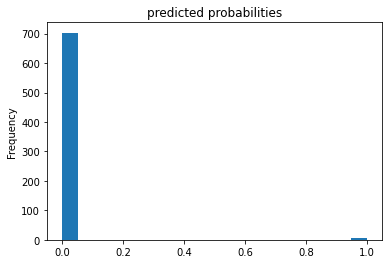

In [ ]:
linear_est_wrs.train(train_input_fn_wr)  
result = linear_est_wrs.evaluate(eval_input_fn_wr)   

pred_dicts = list(linear_est_wrs.predict(eval_input_fn_wr))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='predicted probabilities')

print("\nAccuracy", result['accuracy']) 

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-08-11T18:47:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdacmhncb/model.ckpt-5340
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.58446s
INFO:tensorflow:Finished evaluation at 2021-08-11-18:47:16
INFO:tensorflow:Saving dict for global step 5340: accuracy = 0.8, accuracy_baseline = 0.58, auc = 0.78571427, auc_precision_recall = 0.82033134, average_loss = 4.5019546, global_step = 5340, label/mean = 0.42, loss = 4.7995896, precision = 1.0, prediction/mean = 0.2204683, recall = 0.52380955
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5340: /tmp/tmpdacmhncb/model.ckpt-5340
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdacmhncb/model.ckpt-5340
INFO:tensorflow:Running

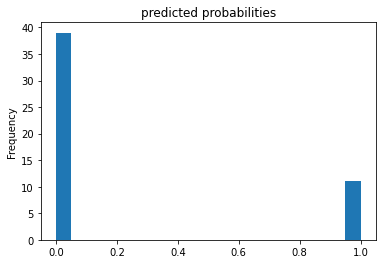

In [ ]:
eval_input_fn_wr = make_input_fn(revised_wr_test, revised_wr_results, num_epochs=1, shuffle=False)

result = linear_est_wrs.evaluate(eval_input_fn_wr)   

pred_dicts = list(linear_est_wrs.predict(eval_input_fn_wr))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='predicted probabilities')

print("\nAccuracy:", result['accuracy'])  

#**Hall of Fame Running Backs**

In [ ]:
hof_rb

,Player,G,Att.1,Yds.1,TD.1
14,"James, Edgerrin",148,3028.0,12246.0,80.0
35,"Davis, Terrell",78,1655.0,7607.0,60.0
38,"Tomlinson, LaDainian",170,3174.0,13684.0,145.0
46,"Bettis, Jerome",192,3479.0,13662.0,91.0
69,"Martin, Curtis",168,3518.0,14101.0,90.0
72,"Faulk, Marshall",176,2836.0,12279.0,100.0
80,"Little, Floyd",117,1641.0,6323.0,43.0
83,"Smith, Emmitt",226,4409.0,18355.0,164.0
99,"Thomas, Thurman",182,2877.0,12074.0,65.0
113,"Sanders, Barry",153,3062.0,15269.0,99.0


In [ ]:
rb_career = pd.read_csv("Career_Stats_Rushing.csv")

# Cleaning Data
rb_career = rb_career.replace(["--"], np.NaN)

rb_career['Att.1'] = rb_career['Att.1'].str.replace(',', '').astype(float)
rb_career["Yds.1"] = rb_career['Yds.1'].str.replace(',', '').astype(float)
rb_career['TD.1'] = rb_career['TD.1'].str.replace(',', '').astype(float)

rb_career = rb_career.groupby("Player")[["G", "Att.1", "Yds.1", "TD.1"]].sum().reset_index()

#Add Columns
hof_rb["YPC"] = (hof_rb["Yds.1"] / hof_rb["Att.1"]).round(decimals = 2)
hof_rb["YPG"] = (hof_rb["Yds.1"] / hof_rb["G"]).round(decimals = 2)
hof_rb["TD/G"] = (hof_rb["TD.1"] / hof_rb["G"]).round(decimals = 2)

rb_career["YPC"] = (rb_career["Yds.1"] / rb_career["Att.1"]).round(decimals = 2)
rb_career["YPG"] = (rb_career["Yds.1"] / rb_career["G"]).round(decimals = 2)
rb_career["TD/G"] = (rb_career["TD.1"] / rb_career["G"]).round(decimals = 2)

hof_rb["HOF"] = 1

all_rbs = pd.concat([hof_rb, rb_career]).drop_duplicates(subset = "Player").reset_index(drop = True)

all_rbs.HOF = all_rbs.HOF.replace([np.nan], 0)
# Make HOF last column
rbs_hof_copy = all_rbs.pop("HOF")
all_rbs["HOF"] = rbs_hof_copy

**Key**

YPC: Yards per carry

YPG: Yards per game

TD/G: Touchdowns per game

HOF: Hall of Famer?

In [ ]:
all_rbs

,Player,G,Att.1,Yds.1,TD.1,YPC,YPG,TD/G,HOF
0,"James, Edgerrin",148,3028.0,12246.0,80.0,4.04,82.74,0.54,1.0
1,"Davis, Terrell",78,1655.0,7607.0,60.0,4.60,97.53,0.77,1.0
2,"Tomlinson, LaDainian",170,3174.0,13684.0,145.0,4.31,80.49,0.85,1.0
3,"Bettis, Jerome",192,3479.0,13662.0,91.0,3.93,71.16,0.47,1.0
4,"Martin, Curtis",168,3518.0,14101.0,90.0,4.01,83.93,0.54,1.0
...,...,...,...,...,...,...,...,...,...
3161,"Zofko, Mickey",44,21.0,67.0,0.0,3.19,1.52,0.00,0.0
3162,"Zolak, Scott",55,38.0,81.0,0.0,2.13,1.47,0.00,0.0
3163,"Zontini, Lou",26,35.0,97.0,3.0,2.77,3.73,0.12,0.0
3164,"Zorn, Jim",140,322.0,1504.0,17.0,4.67,10.74,0.12,0.0


In [ ]:
future_hof_rbs = ["Gore, Frank", "Peterson, Adrian", "Lynch, Marshawn", "Alexander, Shaun", "Forte, Matt", "Charles, Jamaal"]
for hof in future_hof_rbs:
  all_rbs.HOF[all_rbs.Player == hof] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
all_rbs = shuffle(all_rbs)

# Training Data (80%)
rb_train = all_rbs[0:2532]
rb_train_results = rb_train.pop("HOF")

# Testing Data (20%)
rb_test = all_rbs[2532:-1]
rb_test_results = rb_test.pop("HOF")

# Revised Testing Data
rb_random = rb_career[rb_career["Att.1"] > 1000].sample(30)
revised_rb_test = pd.concat([hof_rb, rb_random]).drop_duplicates(subset = "Player").reset_index(drop = True)
revised_rb_test.HOF = revised_rb_test.HOF.replace([np.nan], 0)
revised_rb_test = shuffle(revised_rb_test)
revised_rb_results = revised_rb_test.pop("HOF")

# Feature Columns
feature_columns_rbs = []
columns = ["G", "Att.1", "Yds.1", "TD.1", "YPC", "YPG", "TD/G"]

for column in columns:
  feature_columns_rbs.append(tf.feature_column.numeric_column(column, dtype=tf.float32))

In [ ]:
train_input_fn_rb = make_input_fn(rb_train, rb_train_results)  
eval_input_fn_rb = make_input_fn(rb_test, rb_test_results, num_epochs=1, shuffle=False)

linear_est_rbs = tf.estimator.LinearClassifier(feature_columns = feature_columns_rbs)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpdq87cnpi', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdq87cnpi/model.ckpt-4800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 4800...
INFO:tensorflow:Saving checkpoints for 4800 into /tmp/tmpdq87cnpi/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 4800...
INFO:tensorflow:loss = 0.00091230153, step = 4800
INFO:tensorflow:global_step/sec: 459.78
INFO:tensorflow:loss = 0.000857863, step = 4900 (0.219 sec)
INFO:tensorflow:global_step/sec: 814.282
INFO:tensorflow:loss = 2.2241995, step = 5000 (0.124 sec)
INFO:tensorflow:global_step/sec: 820.58
INFO:tensorflow:loss = 0.00012815664, step = 5100 (0.125 sec)
INFO:tensorflow:global_step/sec: 796.907
INFO:tensorflow:loss = 0.00041839693, step = 5200 (0.126 sec)
INFO:tensorflow:global_step/sec: 77

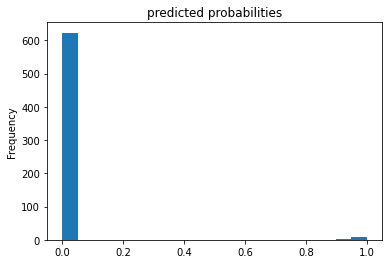

In [ ]:
linear_est_rbs.train(train_input_fn_rb)  
result = linear_est_rbs.evaluate(eval_input_fn_rb)  

pred_dicts = list(linear_est_rbs.predict(eval_input_fn_rb))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='predicted probabilities')

print("\nAccuracy:", result['accuracy'])  

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-08-11T18:46:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdq87cnpi/model.ckpt-7200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.62084s
INFO:tensorflow:Finished evaluation at 2021-08-11-18:46:56
INFO:tensorflow:Saving dict for global step 7200: accuracy = 0.85714287, accuracy_baseline = 0.5510204, auc = 0.8484849, auc_precision_recall = 0.7790331, average_loss = 4.6830816, global_step = 7200, label/mean = 0.4489796, loss = 4.1456995, precision = 0.82608694, prediction/mean = 0.46921337, recall = 0.8636364
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7200: /tmp/tmpdq87cnpi/model.ckpt-7200
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdq87cnpi/model.ckpt-7200
I

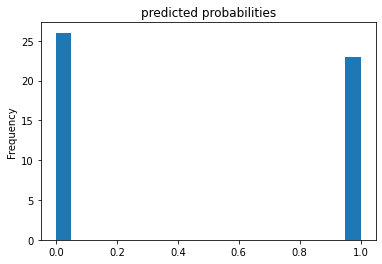

In [ ]:
eval_input_fn_rb = make_input_fn(revised_rb_test, revised_rb_results, num_epochs=1, shuffle=False)

result = linear_est_rbs.evaluate(eval_input_fn_rb)  

pred_dicts = list(linear_est_rbs.predict(eval_input_fn_rb))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='predicted probabilities')

print("\nAccuracy:", result['accuracy'])  

#**Hall of Fame Predictor**

We can now use all the models that we created to make a simple program that asks us to input career stats about a QB, RB, or WR, and predicts if the player is going to make the hall of fame or not.

In [ ]:
def make_input_fn_2(features, num_epochs=1, shuffle=False, batch_size=128):
  def input_function():  
    ds = tf.data.Dataset.from_tensor_slices((dict(features)))  
    if shuffle:
      ds = ds.shuffle(1000)  
    ds = ds.batch(batch_size).repeat(num_epochs)  
    return ds  
  return input_function  

In [ ]:
def predict_qb():
  features = ["G", "Cmp", "Att", "Yds", "TD", "Int", "Cmp%", "YPG"]
  predict = {}
  
  print("Please type numeric values as prompted.")
  for feature in features:
    val = input(feature + ": ")
    predict[feature] = [float(val)]

  predictions = linear_est_qbs.predict(make_input_fn_2(predict))

  for pred_dict in predictions:
      probability = pred_dict['probabilities'][1]
      clear_output()
      if probability > .80:
        print('Hall of Fame: Yes')
      else:
        print("Hall of Fame: No")

In [ ]:
def predict_rb():
  features = ["G", "Att.1", "Yds.1", "TD.1", "YPC", "YPG", "TD/G"]
  predict = {}
  
  print("Please type numeric values as prompted.")
  for feature in features:
    val = input(feature + ": ")
    predict[feature] = [float(val)]

  predictions = linear_est_rbs.predict(make_input_fn_2(predict))

  for pred_dict in predictions:
      probability = pred_dict['probabilities'][1]
      clear_output()
      if probability > .80:
        print('Hall of Fame: Yes')
      else:
        print("Hall of Fame: No")

In [ ]:
def predict_wr():
  features = ["G", "Rec", "Yds.2", "TD.2", "YPR", "YPG", "RPG"]
  predict = {}
  
  print("Please type numeric values as prompted.")
  for feature in features:
    val = input(feature + ": ")
    predict[feature] = [float(val)]

  predictions = linear_est_wrs.predict(make_input_fn_2(predict))

  for pred_dict in predictions:
      probability = pred_dict['probabilities'][1]
      clear_output()
      if probability > .80:
        print('Hall of Fame: Yes')
      else:
        print("Hall of Fame: No")

In [ ]:
position = input("Posit1ion (QB, RB, WR): ")
if position.lower() == "qb":
  predict_qb()
if position.lower() == "rb":
  predict_rb()
if position.lower() == "wr":
  predict_wr()

Hall of Fame: Yes


##**Conclusion**
The Hall of Fame predictor has a 80% + accuracy and it does a good job predicting a players chances of making the Hall of Fame. However, the model could be even more accurate if it had other stats like super bowl championships and pro bowl appearences because this data also has a huge impact on whether a player makes the hall of fame or not.